# Graph2Vec Notebook

The goal of this notebook is to explore the [Karateclub graph2vec implementation](https://karateclub.readthedocs.io/en/latest/index.html) and the associated the WL hashing code and make sure it's doing what I want it to do. 

**Note on WL Labels**:
As I worked through their code, I noticed that, although the WL relabeling was being computed correctly at each step, for some reason only the labels for the two most recent WL iterations was being returned. I modified the code to return the labels for all iterations. Thus, the number of "words" in the "document" is:

    |G| = wl_iter * N

In [1]:
import numpy as np
import networkx as nx
import hashlib
import powerlaw
from utils.embeddings import *
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

## WL Relabeling - Simple Graph

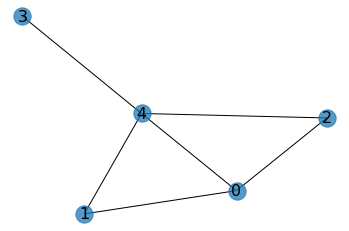

In [2]:
G = nx.Graph()
G.add_edges_from([(0,1), (0,4), (0,2), (1,4), (2,4), (3,4)])
pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=[0,1,2,3,4], alpha=0.75)
nx.draw_networkx_edges(G, pos, width=1.0)

labels={}
labels[0]='0'
labels[1]='1'
labels[2]='2'
labels[3]='3'
labels[4]='4'

nx.draw_networkx_labels(G, pos, labels, font_size=16)

plt.axis('off')
plt.show() 

**1 WL iteration**

The node labels are the number of neighbors they have, and these are concatenated with the (sorted) labels of the neighboring nodes to produce a pre-hash:

| Node | "label" (degree) | Neighbors | pre-hash  |
| --- | --- | --- | --- |
| 0 | 3 | 1, 2, 4 | 3_2_2_4 |
| 1 | 2 | 0, 4 | 2_3_4 |
| 2 | 2 | 0, 4 | 2_3_4 |
| 3 | 1 | 4 | 1_4 |
| 4 | 4 | 0, 1, 2, 3 | 4_1_2_2_3 |

In [3]:
pre_hashes = ['3_2_2_4', '2_3_4', '2_3_4', '1_4', '4_1_2_2_3']
for i in range(len(pre_hashes)):
    print(hashlib.md5(pre_hashes[i].encode()).hexdigest())

a0a62ef89a0bba0fa954aa28cd2fc432
2333804932f554f28075a9a170922ddd
2333804932f554f28075a9a170922ddd
34b8a5e9772cd73daba26c68a209127f
7b69655d0d12c10546123277d624c159


Compare against the KarateClub code:

In [4]:
wl_iter = 1
WL = WeisfeilerLehmanHashing(G, wl_iter, False)
WL.get_node_features()

{0: ['3', 'a0a62ef89a0bba0fa954aa28cd2fc432'],
 1: ['2', '2333804932f554f28075a9a170922ddd'],
 4: ['4', '7b69655d0d12c10546123277d624c159'],
 2: ['2', '2333804932f554f28075a9a170922ddd'],
 3: ['1', '34b8a5e9772cd73daba26c68a209127f']}

I added a "wl_labels" attribute which stores these:

In [5]:
WL.wl_labels

['a0a62ef89a0bba0fa954aa28cd2fc432',
 '2333804932f554f28075a9a170922ddd',
 '7b69655d0d12c10546123277d624c159',
 '2333804932f554f28075a9a170922ddd',
 '34b8a5e9772cd73daba26c68a209127f']

**2 WL iterations**

In [6]:
wl_iter = 2
WL = WeisfeilerLehmanHashing(G, wl_iter, False)
WL.get_node_features()

{0: ['a0a62ef89a0bba0fa954aa28cd2fc432', '897403e1cce354429525383d0c37811c'],
 1: ['2333804932f554f28075a9a170922ddd', '0be51740cd4b2b5d6c3a2e8aaff1e4c8'],
 4: ['7b69655d0d12c10546123277d624c159', '128a90a4edbab0fb0ff240f6ce606d7c'],
 2: ['2333804932f554f28075a9a170922ddd', '0be51740cd4b2b5d6c3a2e8aaff1e4c8'],
 3: ['34b8a5e9772cd73daba26c68a209127f', '15f0b9d91fa1f99c55d5ff6157c882f6']}

In [7]:
WL.wl_labels

['a0a62ef89a0bba0fa954aa28cd2fc432',
 '897403e1cce354429525383d0c37811c',
 '2333804932f554f28075a9a170922ddd',
 '0be51740cd4b2b5d6c3a2e8aaff1e4c8',
 '7b69655d0d12c10546123277d624c159',
 '128a90a4edbab0fb0ff240f6ce606d7c',
 '2333804932f554f28075a9a170922ddd',
 '0be51740cd4b2b5d6c3a2e8aaff1e4c8',
 '34b8a5e9772cd73daba26c68a209127f',
 '15f0b9d91fa1f99c55d5ff6157c882f6']

**3 WL iterations**

Note how the built-in Karateclub function (get_node_features()) just returns the 2 most recent labels, whereas my addition (wl_labels) returns all of the labels.

In [8]:
wl_iter = 3
WL = WeisfeilerLehmanHashing(G, wl_iter, False)
WL.get_node_features()

{0: ['897403e1cce354429525383d0c37811c', '9759ca4a348f9a77118758df27d8c7ac'],
 1: ['0be51740cd4b2b5d6c3a2e8aaff1e4c8', 'c0d6e998bbdef94011b788b4f02256d8'],
 4: ['128a90a4edbab0fb0ff240f6ce606d7c', 'f09c474054c42e581bc69a02b6ba233a'],
 2: ['0be51740cd4b2b5d6c3a2e8aaff1e4c8', 'c0d6e998bbdef94011b788b4f02256d8'],
 3: ['15f0b9d91fa1f99c55d5ff6157c882f6', '4c5ce605fade36272a343c050f4d3969']}

In [9]:
WL.get_graph_features()

['897403e1cce354429525383d0c37811c',
 '9759ca4a348f9a77118758df27d8c7ac',
 '0be51740cd4b2b5d6c3a2e8aaff1e4c8',
 'c0d6e998bbdef94011b788b4f02256d8',
 '128a90a4edbab0fb0ff240f6ce606d7c',
 'f09c474054c42e581bc69a02b6ba233a',
 '0be51740cd4b2b5d6c3a2e8aaff1e4c8',
 'c0d6e998bbdef94011b788b4f02256d8',
 '15f0b9d91fa1f99c55d5ff6157c882f6',
 '4c5ce605fade36272a343c050f4d3969']

Compare the above to what the original graph2vec implementation used as the "words":

In [10]:
WL.wl_labels

['a0a62ef89a0bba0fa954aa28cd2fc432',
 '897403e1cce354429525383d0c37811c',
 '9759ca4a348f9a77118758df27d8c7ac',
 '2333804932f554f28075a9a170922ddd',
 '0be51740cd4b2b5d6c3a2e8aaff1e4c8',
 'c0d6e998bbdef94011b788b4f02256d8',
 '7b69655d0d12c10546123277d624c159',
 '128a90a4edbab0fb0ff240f6ce606d7c',
 'f09c474054c42e581bc69a02b6ba233a',
 '2333804932f554f28075a9a170922ddd',
 '0be51740cd4b2b5d6c3a2e8aaff1e4c8',
 'c0d6e998bbdef94011b788b4f02256d8',
 '34b8a5e9772cd73daba26c68a209127f',
 '15f0b9d91fa1f99c55d5ff6157c882f6',
 '4c5ce605fade36272a343c050f4d3969']

## WL Relabeling - Small-World Graphs

Now let's investigate the WL labels for larger, more realistic graphs. Rather than inspecting the labels for a single graph, I'm now interested in the statistical properties of the labels for a population of graphs.

In [11]:
Graphs_train = []
Graphs_test = []
Ngraphs = 50
Nnodes = 150
for i in range(Ngraphs):
    Graphs_train.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=0.3, seed=i))
    Graphs_test.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=0.3, seed=i))

In [12]:
wl_iter = 3
WLhashes = np.asarray([WeisfeilerLehmanHashing(Graphs_train[i], wl_iter, False).wl_labels \
                       for i in range(len(Graphs_train))])

Check that the right number of labels is being returned:

In [13]:
print(len(Graphs_train)*Nnodes*wl_iter)
print(len(WLhashes.flatten()))

22500
22500


How many of these are unique?

In [14]:
print(len(np.unique(WLhashes.flatten())))

7796


What if we modify the number of WL iterations? As the number of iterations grows, the number of distinct "words" should increase. 

**Note**: Here I am looking at the vocabulary of each WL iteration. So for example, wl_iter = 4 would produce 4 sets of node labels, and I am looking at the vocabulary size of each of these 4 separately.

In [15]:
wl_iter = 10
WLhashes_raw = np.asarray([WeisfeilerLehmanHashing(Graphs_train[i], wl_iter, False).wl_labels \
                       for i in range(len(Graphs_train))])

WLhashes = np.empty((len(Graphs_train), wl_iter, Nnodes), dtype = "S32")

for i in range(len(Graphs_train)):
    for i_wl in range(wl_iter):
        for n in range(Nnodes):
            WLhashes[i, i_wl, n] = WLhashes_raw[i][i_wl + n*wl_iter]

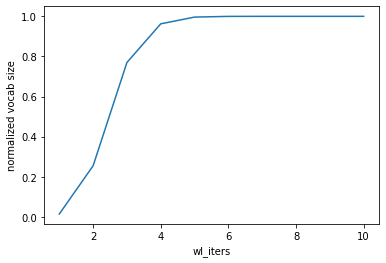

In [16]:
vocab_size = []
for i_wl in range(wl_iter):
    vocab_tmp = []
    for i in range(len(Graphs_train)):
        vocab_tmp = vocab_tmp + list(WLhashes[i, i_wl, :]) #[i_wl*Nnodes:(i_wl+1)*Nnodes])
    vocab_size.append(len(np.unique(vocab_tmp))/(Nnodes*len(Graphs_train)))
    
plt.plot(range(1, wl_iter+1), vocab_size)
plt.xlabel('wl_iters')
plt.ylabel('normalized vocab size')
plt.show()

Does Zipf's law hold? The connection b/w Zipf's law and the Pareto distribution is a bit subtle. I found some explanations in these links:

https://stats.stackexchange.com/questions/91670/connection-between-power-law-and-zipfs-law
https://www.hpl.hp.com/research/idl/papers/ranking/ranking.html
https://en.wikipedia.org/wiki/Pareto_distribution#Relation_to_Zipf's_law

Even with these sources, it seems like a tricky matter to do a rigorous fit, like the kind advocated by Clauset et al. So, I'll just treat this very casually for now, and I can always return to do the fit more carefully later if there is interest.

In [17]:
from sklearn.linear_model import LinearRegression

wl_iter = 3
WLhashes = np.asarray([WeisfeilerLehmanHashing(Graphs_train[i], wl_iter, False).wl_labels \
                       for i in range(len(Graphs_train))])
vocab = np.unique(WLhashes.flatten())

word_freq = {v:0 for v in vocab}
for i in range(len(WLhashes)):
    doc = WLhashes[i]
    for x in doc:
        word_freq[x] += 1
        
frequencies = np.sort(np.asarray(list(word_freq.values())))[::-1]
frequencies = frequencies/np.sum(frequencies)

## fit a line, excluding the first and last few data points
i_min = 10
i_max = 1000
x = np.log(np.asarray([i for i in range(1,len(frequencies)+1)]))[i_min:i_max].reshape(-1, 1)
y = np.log(frequencies)[i_min:i_max].reshape(-1, 1)
model = LinearRegression().fit(x, y)
print('intercept = %.3f' % model.intercept_[0])
print('coefficient = %.3f' % model.coef_[0][0])

intercept = -2.045
coefficient = -1.081


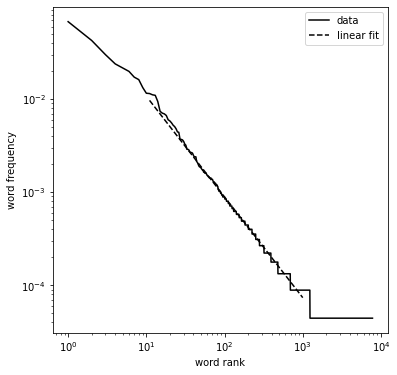

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

## Zipf's law
ax.plot([i for i in range(1,len(frequencies)+1)], frequencies, color='k', label='data')
ax.plot(np.exp(x), np.exp(model.coef_[0][0]*x + model.intercept_[0]), color='k', linestyle='dashed', label='linear fit')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('word rank')
ax.set_ylabel('word frequency')
#ax.tick_params(axis='sci', which='major')
#ax.text(-0.15, 1, 'c', transform=ax.transAxes, size=20)

## save and display
#plt.tight_layout()
#plt.savefig("gensim/figures/corpus_stats.png", bbox_inches='tight')
plt.show()

## Graph2Vec Embeddings

Next I want to explore some properties of the graph2vec embeddings. There are lots of hyper-parameters here to explore, and I'll only be able to look at some of them. The ones I'm most interested in are:

- Doc2Vec model type
    - there are two types, distributed memory (PV-DM) and distributed bag of words (PV-DBOW).
    - these are controlled by the dm parameter, dm=1 gives PV-DM, dm=0 gives PV-DBOW
    - Gensim's default is to set dm=1, i.e. PV-DM, while the KarateClub implementation uses dm=0, i.e. PV-DBOW. This is inline with the Graph2Vec paper which makes very clear that they are considering the PV-DBOW/skipgram version of doc2vec. 
    - Within the PV-DBOW model, there is an additional hyper-parameter dbow_words. If dbow_words=0, then this is the original PV-DBOW model. No word vectors are trained. If dbow_words=1, then word vectors are trained, and the code will be substantially slower.
    - The KarateClub implementation uses Gensim's default of dbow_words=0.
    - these issues are discussed nicely [here](https://stackoverflow.com/questions/44011706/what-is-different-between-doc2vec-models-when-the-dbow-words-is-set-to-1-or-0).
    - dbow_words = 0 should be used because the other option is poorly suited for MCMC applications, since each new word requires a new word vector to be learned.
- dimension of the embedding
    - How should this be chosen? Too small and the representation will be too condensed. Too large and it may overfit.
- training epochs
    - I found a few online references that said this should be set to 10-20, for example see the answers to [this SE question](https://www.google.com/search?q=gensim+doc2vec+loss&rlz=1C5CHFA_enUS759US759&oq=gensim+doc2vec+loss&aqs=chrome..69i57j35i39l2j0l2j69i60l3.7399j0j7&sourceid=chrome&ie=UTF-8). The KarateClub default is 10 (this value is used for both training and inference epochs). 
- inference epochs
    - The entire ERGM relies on being able to compute f(G) for new graphs. However, Graph2Vec solves for new feature vectors in an approximate way. The error should go down with more epochs. How quickly does the error drop, and what levels of error are acceptable?


### Inference error as a function of epochs and embedding dimension

Set dbow_words=0 (w/o word vector training), in-line with the above discussion. Also set training_epochs=20.

In [19]:
dim_list = [5, 10, 20, 40, 80, 160]
epoch_list = [int((1.4)**i) for i in range(4, 24)]
alpha_list = [0.00025*2**i for i in range(0,9)]

error_list_real_vs_inf = np.zeros((len(dim_list), len(alpha_list), len(epoch_list)))
error_list_inf_vs_inf = np.zeros((len(dim_list), len(alpha_list), len(epoch_list)))
training_epochs = 20

for i_dim in range(len(dim_list)):
    dim = dim_list[i_dim]
    
    for i_alpha in range(len(alpha_list)):
        alpha = alpha_list[i_alpha]
        
        ## train the graph2vec model
        g2vModel = Graph2Vec(wl_iterations=4, attributed=False, dimensions=dim, workers=4,
                 down_sampling=0.0001, epochs=training_epochs, alpha=alpha, min_count=5,
                 seed=42, dbow_words=0)

        g2vModel.fit(Graphs_train)    
        true_vecs = g2vModel.get_embedding()

        for i_epoch in range(len(epoch_list)):
            inferred_vecs1 = np.zeros((len(Graphs_train), dim))
            inferred_vecs2 = np.zeros((len(Graphs_train), dim))
            for i in range(len(Graphs_train)):
                inferred_vecs1[i,:] = g2vModel.infer_vector(Graphs_train[i], epochs=epoch_list[i_epoch])
                inferred_vecs2[i,:] = g2vModel.infer_vector(Graphs_train[i], epochs=epoch_list[i_epoch])
            error_list_real_vs_inf[i_dim, i_alpha, i_epoch] = np.mean(np.sqrt(np.sum(np.square(true_vecs - inferred_vecs1), axis=1)))
            error_list_inf_vs_inf[i_dim, i_alpha, i_epoch] = np.mean(np.sqrt(np.sum(np.square(inferred_vecs1 - inferred_vecs2), axis=1)))

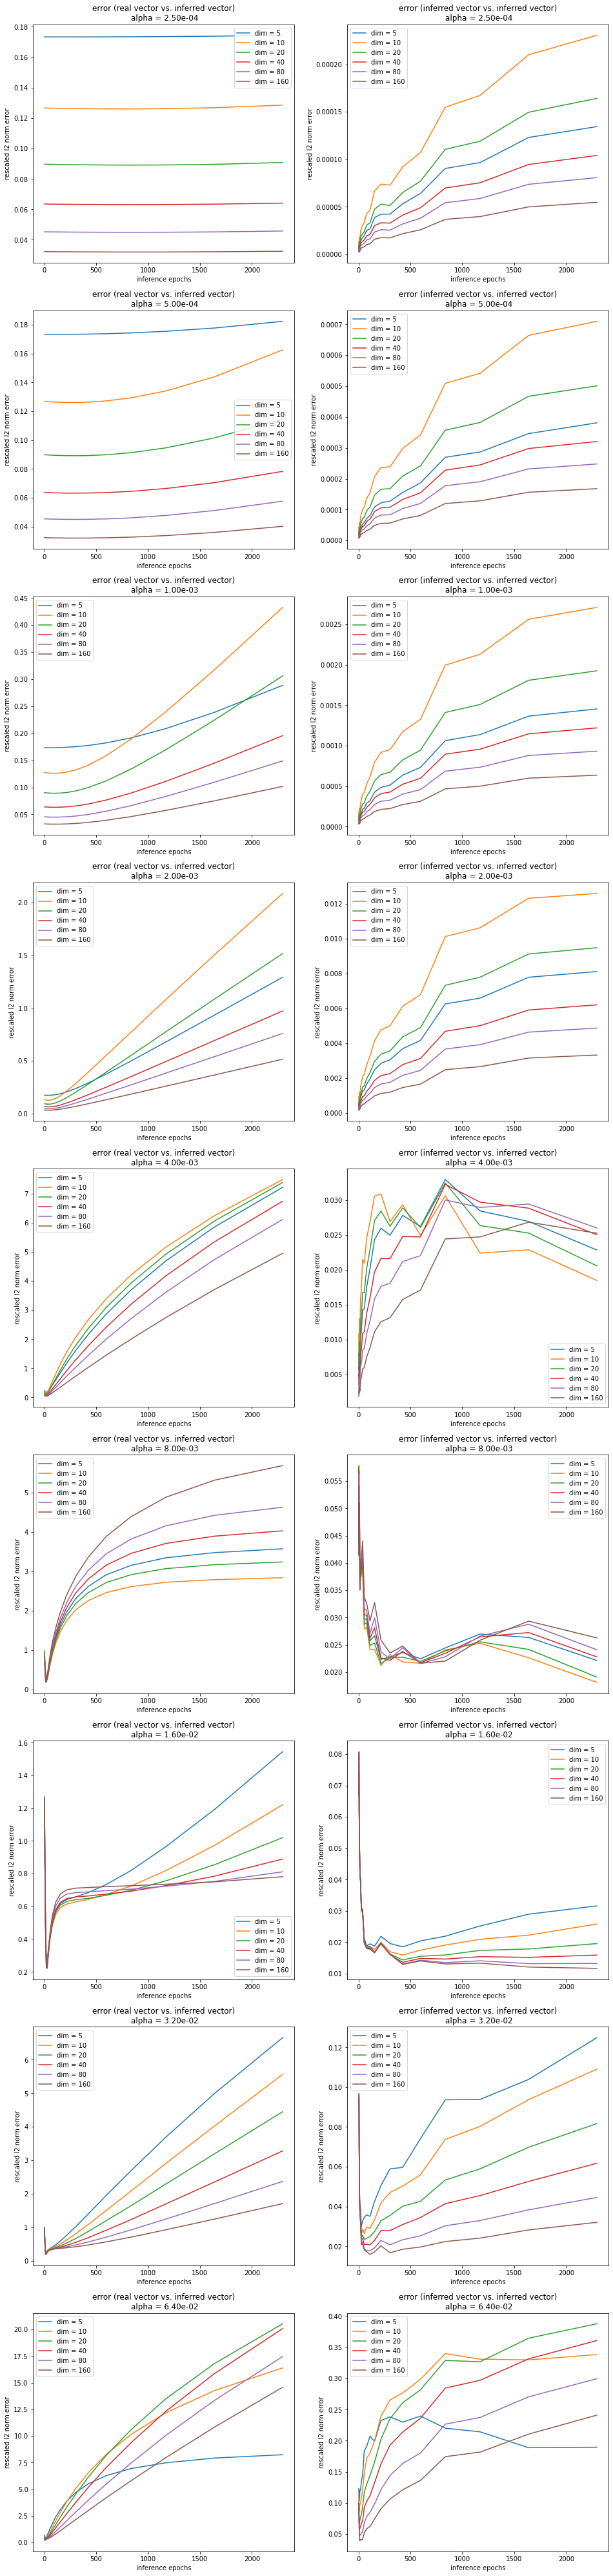

In [20]:
fig, axarr = plt.subplots(len(alpha_list), 2, figsize=(2*2*4, 2*len(alpha_list)*4))

for i_alpha in range(len(alpha_list)):
    for i_dim in range(len(dim_list)):
        axarr[i_alpha, 0].plot(epoch_list, error_list_real_vs_inf[i_dim, i_alpha], label='dim = %i' %dim_list[i_dim])
        axarr[i_alpha, 1].plot(epoch_list, error_list_inf_vs_inf[i_dim, i_alpha], label='dim = %i' %dim_list[i_dim])

    axarr[i_alpha, 0].set_xlabel('inference epochs')
    axarr[i_alpha, 0].set_ylabel('rescaled l2 norm error')
    axarr[i_alpha, 0].legend()
    axarr[i_alpha, 0].set_title('error (real vector vs. inferred vector)\n alpha = %.2e' %alpha_list[i_alpha])

    axarr[i_alpha, 1].set_xlabel('inference epochs')
    axarr[i_alpha, 1].set_ylabel('rescaled l2 norm error')
    axarr[i_alpha, 1].legend()
    axarr[i_alpha, 1].set_title('error (inferred vector vs. inferred vector)\n alpha = %.2e' %alpha_list[i_alpha])

plt.show()

I'm not going to do a systematic scan of the hyper-parameters, and even if I did, I'm not sure what criteria I would use to pick the optimal choice of hyper-parameters. However, the case of alpha = 0.016, and epochs = 28 seems reasonable for a range of vector dimensions:

alpha =  0.016
dim =  80
epoch =  28


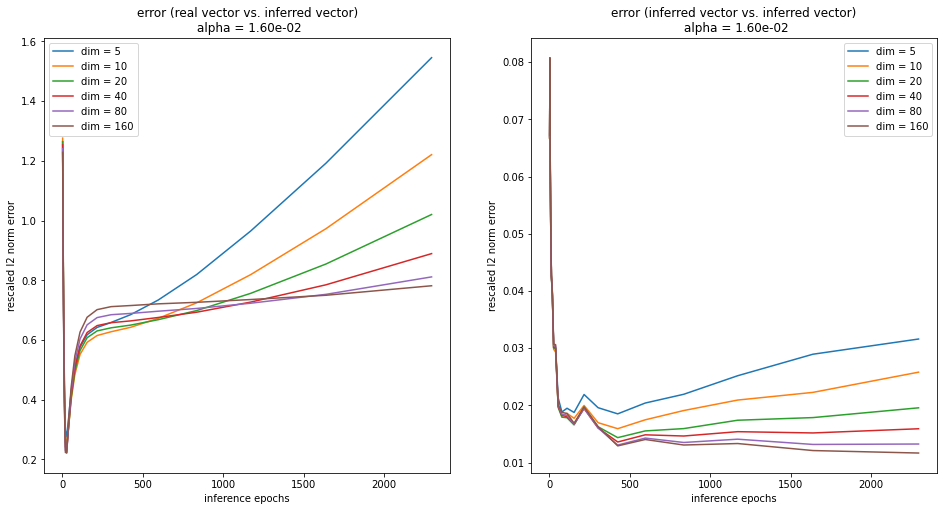

In [21]:
i_alpha = 6
i_dim = 4
print('alpha = ', alpha_list[i_alpha])
print('dim = ', dim_list[i_dim])
print('epoch = ', epoch_list[np.argmin(error_list_real_vs_inf[i_dim, i_alpha])])

fig, axarr = plt.subplots(1, 2, figsize=(2*2*4, 2*4))

for i_alpha in [i_alpha]:
    for i_dim in range(len(dim_list)):
        axarr[0].plot(epoch_list, error_list_real_vs_inf[i_dim, i_alpha], label='dim = %i' %dim_list[i_dim])
        axarr[1].plot(epoch_list, error_list_inf_vs_inf[i_dim, i_alpha], label='dim = %i' %dim_list[i_dim])

    axarr[0].set_xlabel('inference epochs')
    axarr[0].set_ylabel('rescaled l2 norm error')
    axarr[0].legend()
    axarr[0].set_title('error (real vector vs. inferred vector)\n alpha = %.2e' %alpha_list[i_alpha])

    axarr[1].set_xlabel('inference epochs')
    axarr[1].set_ylabel('rescaled l2 norm error')
    axarr[1].legend()
    axarr[1].set_title('error (inferred vector vs. inferred vector)\n alpha = %.2e' %alpha_list[i_alpha])

plt.show()

How does this change as the dimension increases?

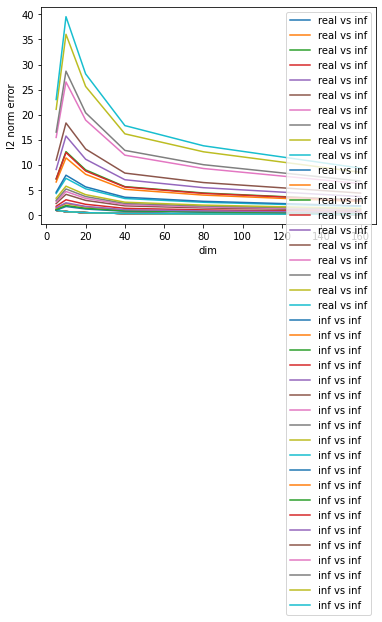

In [22]:
plt.plot(dim_list, np.min(error_list_real_vs_inf, axis=1)/np.min(error_list_real_vs_inf[0]), label='real vs inf')
plt.plot(dim_list, np.min(error_list_inf_vs_inf, axis=1)/np.min(error_list_inf_vs_inf[0]), label='inf vs inf')
plt.xlabel('dim')
plt.ylabel('l2 norm error')
plt.legend()
plt.show()

### Dataset Feature Distribution

Investigate the distribution of the feature vector components $f_i$ for graphs in the dataset.

In [23]:
Graphs_train = []
Graphs_test = []
Ngraphs = 2000
Nnodes = 150
for i in range(Ngraphs):
    Graphs_train.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=np.random.uniform(), seed=i))
    Graphs_test.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=np.random.uniform(), seed=i))

In [24]:
wl = 2
dim = 16

g2vModel = Graph2Vec(wl_iterations=wl, attributed=False, dimensions=dim, workers=4,
             down_sampling=0.0001, epochs=32, alpha=0.016, min_count=5,
             seed=42)

g2vModel.fit(Graphs_train)    
f_data = g2vModel.get_embedding()

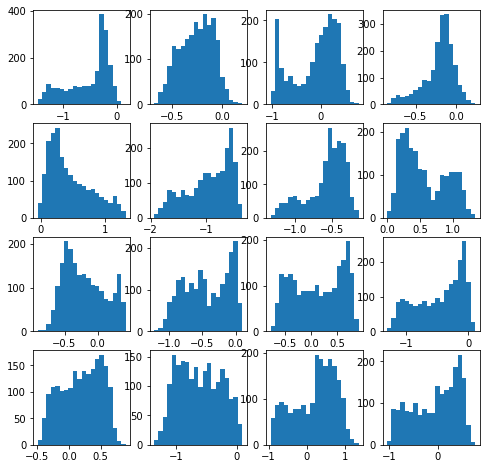

In [25]:
fig, axarr = plt.subplots(4, 4, figsize=(4*2,4*2))
i_f = 0
for i1 in range(4):
    for i2 in range(4):
        axarr[i1, i2].hist(f_data[:,i_f], bins=20)
        #axarr[i1, i2].axvline(x=favg_data[i_f], color='k')
        i_f += 1
plt.show()

### Performance of the Graph2Vec representations on out-of-distribution graphs

The original graph2vec paper touted the learned representations as being useful for downstream tasks, such as graph clustering and classification. An important point is that in their experiments, they train the embeddings on the same dataset of graphs that they use in the testing. In contrast, for the Neural ERGM application, we want to learn an embedding that remains meaningful on arbitrary graphs.

Here, I want to tell if the embeddings can be used to discriminate between graphs that come from different distributions. I'll consider 1) small-world and 2) ER random graphs. A key issue is whether the features can be used to distinguish these two types of graphs even if the graph2vec model was only trained using 1 of the 2 distributions. If so, than this is promising for the Neural ERGM application.

#### Same distribution for training and testing

Both distributions are an equal mix of ER and small-world graphs. In this case the graph2vec embeddings can be used to perfectly distinguish the two types of graphs in an unsupervised clustering setting.

In [69]:
Graphs_train = [] 
Graphs_test = [] 
Ngraphs = 2000
Nnodes = 150

for i in range(Ngraphs//2):
    Graphs_train.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=0.2))
    Graphs_test.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=0.2))
    
for i in range(Ngraphs//2):
    Graphs_train.append(nx.erdos_renyi_graph(n=Nnodes, p=0.05))
    Graphs_test.append(nx.erdos_renyi_graph(n=Nnodes, p=0.05))

In [70]:
wl = 2
dim = 16

g2vModel = Graph2Vec(wl_iterations=wl, attributed=False, dimensions=dim, workers=4,
             down_sampling=0.0001, epochs=32, alpha=0.016, min_count=5,
             seed=42)

g2vModel.fit(Graphs_train)    
f_train = g2vModel.get_embedding()

In [71]:
f_test = np.zeros((len(Graphs_test), dim))

for i in range(len(Graphs_test)):
    f_test[i,:] = g2vModel.infer_vector(Graphs_test[i])

In [72]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(f_test)

Look at the labels of the small-world/ER graphs:

In [73]:
print('avg label of small-world: ', np.mean(kmeans.labels_[0:len(f_test)//2]))
print('avg label of ER: ', np.mean(kmeans.labels_[len(f_test)//2:]))

avg label of small-world:  0.0
avg label of ER:  1.0


#### Different distributions for training and testing

Now only train the graph2vec on small-world, but test on an equal mix of both.

In [74]:
Graphs_train = [] 

for i in range(Ngraphs):
    Graphs_train.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=0.2))

In [75]:
wl = 2
dim = 16

g2vModel = Graph2Vec(wl_iterations=wl, attributed=False, dimensions=dim, workers=4,
             down_sampling=0.0001, epochs=32, alpha=0.016, min_count=5,
             seed=42)

g2vModel.fit(Graphs_train)    
f_train = g2vModel.get_embedding()

In [76]:
f_test = np.zeros((len(Graphs_test), dim))

for i in range(len(Graphs_test)):
    f_test[i,:] = g2vModel.infer_vector(Graphs_test[i])

Look at the labels of the small-world/ER graphs:

In [77]:
print('avg label of small-world: ', np.mean(kmeans.labels_[0:len(f_test)//2]))
print('avg label of ER: ', np.mean(kmeans.labels_[len(f_test)//2:]))

avg label of small-world:  0.0
avg label of ER:  1.0


#### experiment to see effect of to flipping edges

The MCMC algorithm I use to train and sample the ERGM relies on flipping edges, one at a time. I want to see how these local moves affect the feature vector. I'll consider a sequence of graphs $G_0, G_1, ..., G_n$, which are related by edge flips. The associated feature vectors are $f_0, f_1, ..., f_n$. I'll look at the cosine distance between $f_0$, $f_i$, for $i=0,1,...,n$. Also, I'll average this over many starting graphs.

In [78]:
def flip(graph):
    G = graph.copy()
    edges = list(G.edges)
    nonedges = list(nx.non_edges(G))
    isDelete = np.random.randint(0, 2)
    
    if isDelete == 0:
        i, j = edges.pop(np.random.choice(len(edges)))
        G.remove_edge(i, j)
    else:
        i, j = nonedges.pop(np.random.choice(len(nonedges)))
        G.add_edge(i, j)
        
    return G

In [79]:
def nflips(G, n_flips):
    for n in range(n_flips):
        G = flip(G)
    return G

In [ ]:
## use the test data, and only look at the small-world test graphs

max_flips = 20
cosine_dists = np.zeros((len(Graphs_test)//2, max_flips))

for i in range(len(Graphs_test)//2):
    for n_flips in range(max_flips):
        G = Graphs_test[i]
        f0 = g2vModel.infer_vector(G)        
        G = nflips(G, n_flips)            
        f = g2vModel.infer_vector(G)
        cosine_dists[i, n_flips] = scipy.spatial.distance.cosine(f0, f)

In [ ]:
plt.plot(range(20), np.mean(cosine_dists, axis=0))
plt.xlabel('nflips')
plt.ylabel('cosine distance')
plt.show()

#### Are the representations able to capture meaningful notions of variation?

For example, the parameters of a random graph distribution.

In [ ]:
## use the test data, and only look at the small-world test graphs

Graphs_smallworld = []
plist = np.linspace(0.05, 0.5, 500)
cosine_dists = np.zeros((len(Graphs_test)//2, len(plist)))

for i in range(len(plist)):
    Graphs_smallworld.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=plist[i]))

for j in range(len(Graphs_test)//2):
    f0 = g2vModel.infer_vector(Graphs_test[j])
    for i in range(len(plist)):
        fi = g2vModel.infer_vector(Graphs_smallworld[i])
        cosine_dists[j, i] = scipy.spatial.distance.cosine(f0, fi)

In [ ]:
plt.plot(plist, np.mean(cosine_dists, axis=0))
plt.xlabel('p')
plt.ylabel('cosine distance')
plt.show()